In [1]:
import sys
import tensorflow as tf
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
from skimage.util import montage as montage2d
from glob import glob
import numpy as np
import os
from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

%load_ext autoreload
%autoreload 2

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [10]:
sys.path.append("..")
from config import PATH_TO_AFF_MNIST_DATA
from spatial_transform.aff_mnist_data import IMAGE_SIZE, IMAGE_SHAPE, IMAGE_NUM_CHANNELS, get_aff_mnist_data
from spatial_transform.spatial_transforms import AffineTransform
from spatial_transform.st_blocks import SimpleSpatialTransformBlock
from spatial_transform.localization import StandardConvolutionalLocalizationLayer, CoordConvLocalizationLayer
from spatial_transform.interpolation import BilinearInterpolator
from spatial_transform.visualization import show_train_progress

In [5]:
train_img_data, train_img_label, validation_img_data, validation_img_label, test_img_data, test_img_label = get_aff_mnist_data()

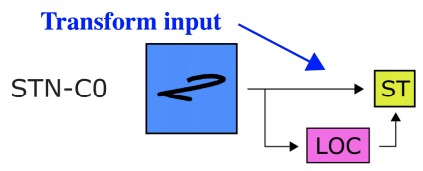

In [3]:
Image("../images/stn_c0.png")

In [4]:
image = tf.keras.layers.Input(shape=IMAGE_SHAPE + (IMAGE_NUM_CHANNELS,))
size_after_transform = 30

spatial_transform = AffineTransform()
st_block = SimpleSpatialTransformBlock(
    localization_layer = CoordConvLocalizationLayer(
        spatial_transform_params_cls = spatial_transform.param_type,
        init_scale = size_after_transform / IMAGE_SIZE,
    ),
    spatial_transform = spatial_transform,
    interpolator = BilinearInterpolator(),
    shape_out = (size_after_transform, size_after_transform)
)

x = image
x = st_block(x)
x = tf.keras.layers.Conv2D(32, [7, 7], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, [5, 5], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(90, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation=None)(x)

model = tf.keras.models.Model(inputs=image, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
simple_spatial_transform_blo (None, 30, 30, 1)         22662     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        1600      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0     

In [6]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [7]:
history = model.fit(
    x = train_img_data, 
    y = train_img_label, 
    batch_size = 128,
    epochs = 6,
    validation_data = (test_img_data,  test_img_label),
    validation_batch_size = 1024,
)

Epoch 1/6
12500/12500 [==============================] - 192s 15ms/step - loss: 0.9142 - accuracy: 0.7293 - val_loss: 0.0509 - val_accuracy: 0.9837
Epoch 2/6
12500/12500 [==============================] - 182s 15ms/step - loss: 0.0526 - accuracy: 0.9835 - val_loss: 0.0397 - val_accuracy: 0.9874
Epoch 3/6
12500/12500 [==============================] - 185s 15ms/step - loss: 0.0353 - accuracy: 0.9888 - val_loss: 0.0387 - val_accuracy: 0.9877
Epoch 4/6
12500/12500 [==============================] - 179s 14ms/step - loss: 0.0268 - accuracy: 0.9915 - val_loss: 0.0347 - val_accuracy: 0.9893
Epoch 5/6
12500/12500 [==============================] - 177s 14ms/step - loss: 0.0218 - accuracy: 0.9930 - val_loss: 0.0279 - val_accuracy: 0.9913
Epoch 6/6
12500/12500 [==============================] - 183s 15ms/step - loss: 0.0180 - accuracy: 0.9942 - val_loss: 0.0265 - val_accuracy: 0.9918


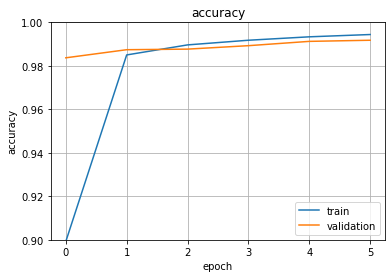

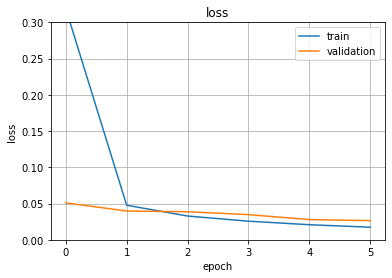

In [11]:
show_train_progress(history)

In [9]:
#model.save_weights("Basic_STN_coord_network_0082.h5")

### Investigate transformed features

In [25]:
images = tf.cast(tf.expand_dims(test_img_data[0:20], 3), dtype=tf.float32)
labels = test_img_label[0:20]

In [26]:
transformed_images = st_block(images)

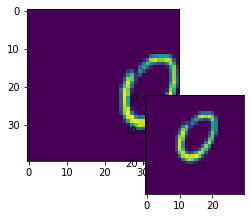

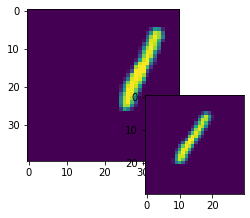

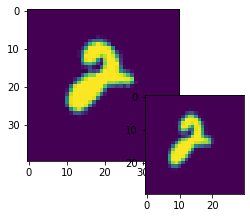

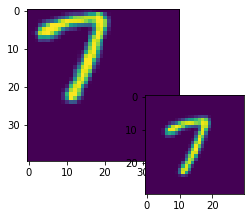

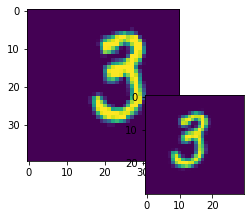

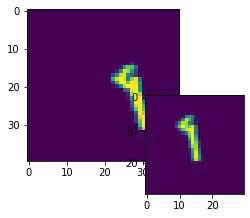

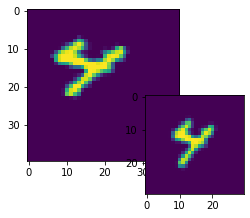

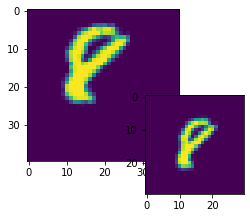

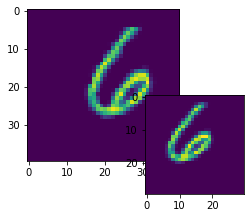

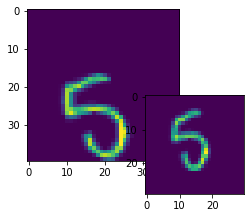

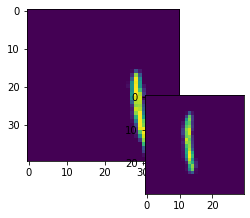

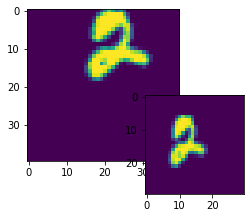

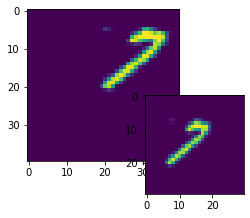

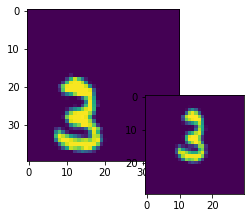

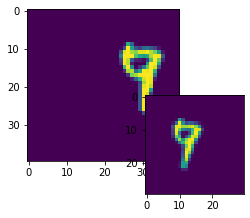

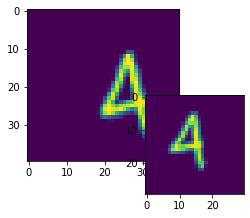

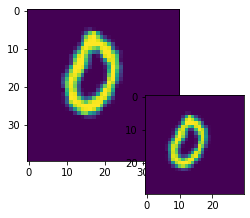

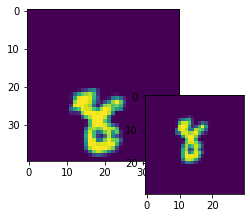

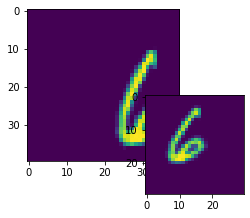

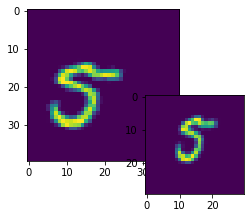

In [27]:
for image_orig, image, label in zip(images, transformed_images, labels):
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image_orig.numpy()[:,:])
    ax2 = fig.add_subplot(2,1,2)
    ax2.imshow(image.numpy()[:,:,0])

### Investigate transformed features for digit "2"

In [48]:
indices = np.where(test_img_label==2)[0][:20]

In [50]:
images = tf.cast(tf.expand_dims(test_img_data[indices], 3), dtype=tf.float32)

In [51]:
transformed_images = st_block(images)

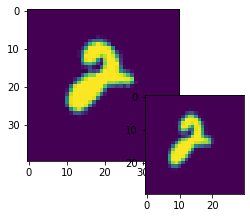

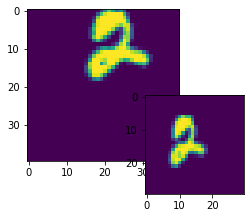

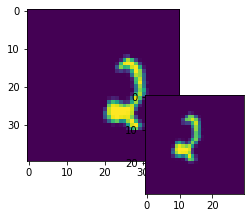

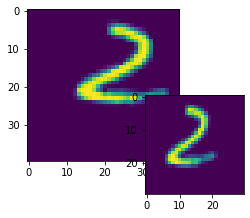

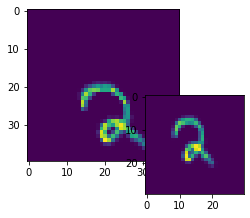

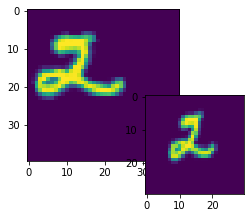

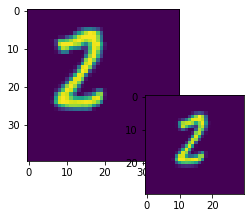

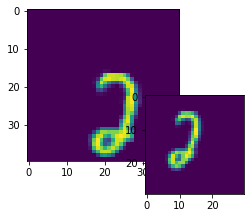

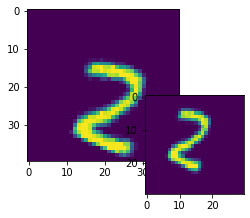

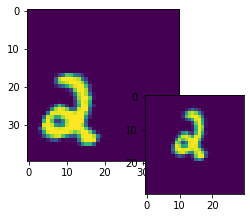

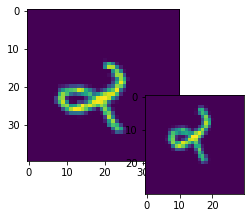

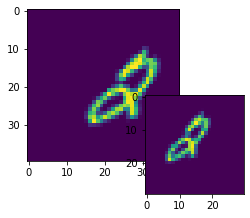

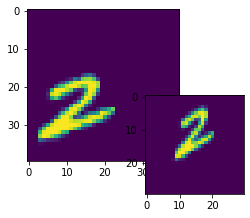

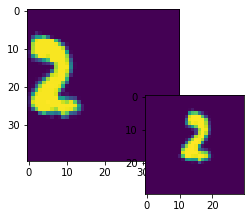

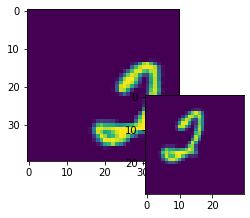

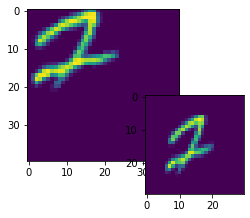

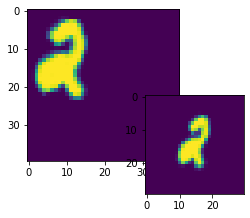

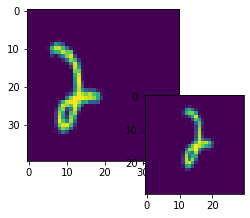

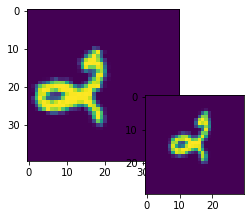

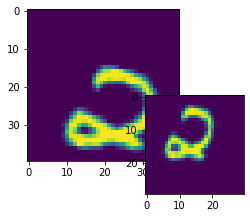

In [52]:
for image_orig, image, label in zip(images, transformed_images, labels):
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image_orig.numpy()[:,:])
    ax2 = fig.add_subplot(2,1,2)
    ax2.imshow(image.numpy()[:,:,0])